In [0]:
from pyspark.sql.functions import col, isnan, when, count, udf, explode, col
import json 
import pandas as pd
import requests
import scipy
import sklearn
import seaborn as sns
import matplotlib as mpl
import plotly
import boto3
from pyspark.sql.functions import col, isnan, when, count, udf
sc.setLogLevel("ERROR")

In [0]:
import os
# To work with Amazon S3 storage, set the following variables using your AWS
# Set the Region to where your files are stored in S3.
access_key = ''
secret_key = ''
# Set the environment variables so boto3 can pick them up later
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F")
aws_region = "us-east-2"
# Update the Spark options to work with our AWS Credentials
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region +
".amazonaws.com")

In [0]:
sdf2 = spark.read.parquet(f"s3://steam-reviews-sd/raw/steam_reviews.parquet")
sdf = sdf2.sample(False,0.01)
sdf.show(10)

+--------------------+-------------+--------+-----------------+----------------+--------------------+-----------------+-----------------+--------+--------+--------------------+-----------+---------------+-----------+------------------+----------------+-----------------------+
|              author|comment_count|language|received_for_free|recommendationid|              review|timestamp_created|timestamp_updated|voted_up|votes_up| weighted_vote_score|last_played|num_games_owned|num_reviews|playtime_at_review|playtime_forever|playtime_last_two_weeks|
+--------------------+-------------+--------+-----------------+----------------+--------------------+-----------------+-----------------+--------+--------+--------------------+-----------+---------------+-----------+------------------+----------------+-----------------------+
|{1469992460, 2, 1...|            0| english|            false|        15421032|good game, well p...|       1429305957|       1429305957|    true|       1|0.523809552192

In [0]:
from pyspark.sql.functions import col, unix_timestamp
from pyspark.sql.types import DateType, TimestampType
from pyspark.sql.functions import col, dayofweek, month, year
# Turn the timestamps into actual datetime columns
# timestamp_created   Looks solid
# timestamp_dev_responded  Mostly Null
# timestamp_updated   Looks solid
# Show some records
sdf.select("timestamp_created","timestamp_updated", "last_played").show(5)
# Check the stats
sdf.select("timestamp_created", "timestamp_updated", "last_played").summary("count", "min", "max").show()

# Convert timestamp_created into an actual DateTime column
sdf = sdf.withColumn("timestamp_created_dt", sdf.timestamp_created.cast(TimestampType()) )
# Convert timestamp_updated into an actual DateTime column
sdf = sdf.withColumn("timestamp_updated_dt", sdf.timestamp_updated.cast(TimestampType()) )
# Convert timestamp_updated into an actual DateTime column
sdf = sdf.withColumn("last_played_dt", sdf.timestamp_updated.cast(TimestampType()) )

sdf.select("timestamp_created", "timestamp_updated", "last_played", "timestamp_created_dt", "timestamp_updated_dt", "last_played_dt").show(5)

from pyspark.sql.functions import weekofyear
sdf = sdf.withColumn('week_of_year_created', weekofyear('timestamp_created_dt'))
sdf = sdf.withColumn('day_of_week', dayofweek('timestamp_created_dt'))
sdf = sdf.withColumn('month', month('timestamp_created_dt'))
sdf = sdf.withColumn('year', year('timestamp_created_dt'))
sdf.select('timestamp_created_dt', 'week_of_year_created', 'day_of_week', 'month', 'year').show()

+-----------------+-----------------+-----------+
|timestamp_created|timestamp_updated|last_played|
+-----------------+-----------------+-----------+
|       1429305957|       1429305957| 1469992460|
|       1429304516|       1429304516| 1590590078|
|       1441488040|       1441488040| 1660169107|
|       1441487235|       1441487235| 1604786999|
|       1573432323|       1573432323| 1657792938|
+-----------------+-----------------+-----------+
only showing top 5 rows

+-------+-----------------+-----------------+-----------+
|summary|timestamp_created|timestamp_updated|last_played|
+-------+-----------------+-----------------+-----------+
|  count|            10755|            10755|      10755|
|    min|       1345172334|       1345172334| 1397742788|
|    max|       1660524598|       1660600535| 1660635601|
+-------+-----------------+-----------------+-----------+

+-----------------+-----------------+-----------+--------------------+--------------------+-------------------+
|times

In [0]:
#Using bucketing to make the maximum threshold for num_reviews 4
from pyspark.ml.feature import Bucketizer
#Splitting the data

splits = [0,1,2,3,4, float('Inf')]
buck = Bucketizer(splits=splits, inputCol = 'num_reviews', outputCol='total_reviews')
sdf = buck.transform(sdf)

In [0]:
from pyspark.sql.functions import col, isnan, when, count, udf, length

# Find the length of review text
sdf = sdf.withColumn("review_length", length(col("review")))
sdf.select("review_length").summary("count", "min", "max", "mean").show()

+-------+-----------------+
|summary|    review_length|
+-------+-----------------+
|  count|            10755|
|    min|                0|
|    max|             8000|
|   mean|83.48665736866573|
+-------+-----------------+



In [0]:
# Remove reviews where the review length is more than 500 characters
sdf = sdf.where(col("review_length") <= 500 )

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import RegexTokenizer


In [0]:
sc.setLogLevel("ERROR")
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, HashingTF, IDF, StringIndexer, OneHotEncoder, VectorAssembler
sdf = sdf.drop("review_words")

# Tokenization and TF-IDF
regexTokenizer = RegexTokenizer(inputCol="review", outputCol="review_words", pattern="\\w+", gaps=False)
hashingTF = HashingTF(numFeatures=4096, inputCol="review_words", outputCol="review_word_features")
idf = IDF(inputCol='review_word_features', outputCol="review_features", minDocFreq=1)

# Creating a label for voted_up
sdf = sdf.withColumn("label", when(sdf.voted_up == True, 1.0).otherwise(0.0))

trainingData,testData = sdf.randomSplit([0.70, 0.3], seed=42)

# Define and apply the remaining stages
assembler = VectorAssembler(inputCols=['week_of_year_created', 'total_reviews', 'review_features'], outputCol="features")

# Create the pipeline
steam_pipe = Pipeline(stages=[regexTokenizer, hashingTF, idf, assembler])

# Fit and transform the data
transformed_sdf = steam_pipe.fit(sdf).transform(sdf)


# Review the transformed features
transformed_sdf.select('week_of_year_created','review_features', 'num_reviews', 'votes_up', 'label', 'features').show(30, truncate=False)
lr = LogisticRegression(maxIter=5)

steam_pipe = Pipeline(stages=[regexTokenizer, hashingTF, idf, assembler, lr])




+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
# Import the logistic regression model
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
# Import the evaluation module
from pyspark.ml.evaluation import *
# Import the model tuning module
from pyspark.ml.tuning import *
import numpy as np

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define your evaluator
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

# Create a grid to hold hyperparameters
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.5, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 1])
# Build the grid
grid = grid.build()
print('Number of models to be tested: ', len(grid))

# Create the CrossValidator using the new hyperparameter grid
cv = CrossValidator(estimator=steam_pipe, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3)

# Call cv.fit() to create models with all of the combinations of parameters in the grid
all_models = cv.fit(trainingData)

#print("Coefficients: ", all_models.coefficients)
#print("Intercept: ", all_model.intercept)


# Test the predictions
predictions = all_models.transform(testData)

# Evaluate the best model using the evaluator
best_model_evaluation = evaluator.evaluate(predictions)
print(f"Best Model Evaluation: {best_model_evaluation}")


Number of models to be tested:  6
Best Model Evaluation: 0.8521173905281679


In [0]:

test_results = all_models.transform(testData)
# Calculate AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")
test_results.select('week_of_year_created', 'votes_up', 'num_reviews', 'rawPrediction','probability','prediction','label').show(truncate=False)
test_results.groupby('label').pivot('prediction').count().sort('label').show()

# Create the confusion matrix
predictions.groupby('label').pivot('prediction').count().fillna(0).show()
cm = predictions.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(cm) )

AUC: 0.8521179218416599
+--------------------+--------+-----------+----------------------------------------+----------------------------------------+----------+-----+
|week_of_year_created|votes_up|num_reviews|rawPrediction                           |probability                             |prediction|label|
+--------------------+--------+-----------+----------------------------------------+----------------------------------------+----------+-----+
|31                  |0       |7          |[-1.9556193140111882,1.9556193140111882]|[0.1239419207944242,0.8760580792055758] |1.0       |0.0  |
|46                  |1       |1          |[-2.1464661468638195,2.1464661468638195]|[0.10466191036754563,0.8953380896324543]|1.0       |1.0  |
|17                  |0       |1          |[-2.2721653903810486,2.2721653903810486]|[0.09345459698575113,0.9065454030142489]|1.0       |1.0  |
|23                  |0       |3          |[1.3135367882513909,-1.3135367882513909]|[0.7881043867082388,0.211895613291

In [0]:
# Gather the metrics and parameters of the model with the best average metrics
hyperparams = all_models.getEstimatorParamMaps()[np.argmax(all_models.avgMetrics)]
# Print out the list of hyperparameters for the best model
for i in range(len(hyperparams.items())):
 print([x for x in hyperparams.items()][i])

(Param(parent='LogisticRegression_591aa847bd07', name='regParam', doc='regularization parameter (>= 0).'), 0.5)
(Param(parent='LogisticRegression_591aa847bd07', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 0.0)


In [0]:
cv_model = cv.fit(trainingData)

# Access the best model from the CrossValidatorModel
best_model = cv_model.bestModel

# Test the predictions on the test data
predictions = best_model.transform(testData)

best_model_evaluation = evaluator.evaluate(predictions)
print(f"Best Model Evaluation: {best_model_evaluation}")

Best Model Evaluation: 0.8521078268853128


LogisticRegression_591aa847bd07__aggregationDepth 2
LogisticRegression_591aa847bd07__elasticNetParam 0.0
LogisticRegression_591aa847bd07__family auto
LogisticRegression_591aa847bd07__featuresCol features
LogisticRegression_591aa847bd07__fitIntercept True
LogisticRegression_591aa847bd07__labelCol label
LogisticRegression_591aa847bd07__maxBlockSizeInMB 0.0
LogisticRegression_591aa847bd07__maxIter 5
LogisticRegression_591aa847bd07__predictionCol prediction
LogisticRegression_591aa847bd07__probabilityCol probability
LogisticRegression_591aa847bd07__rawPredictionCol rawPrediction
LogisticRegression_591aa847bd07__regParam 0.5
LogisticRegression_591aa847bd07__standardization True
LogisticRegression_591aa847bd07__threshold 0.5
LogisticRegression_591aa847bd07__tol 1e-06


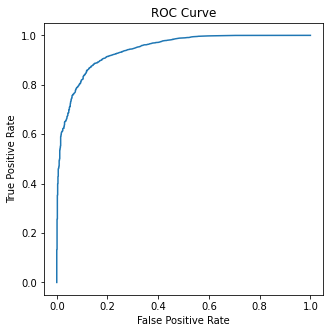

In [0]:
# Look at the parameters for the best model that was evaluated from the grid
param_map = best_model.stages[-1].extractParamMap()

for param, value in param_map.items():
    print(param, value)

# Grab the model from the last stage of the pipeline
mymodel = best_model.stages[-1]

import matplotlib.pyplot as plt
# Get ROC curve data
roc_data = mymodel.summary.roc.toPandas()

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(roc_data['FPR'], roc_data['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [0]:
# Extract the coefficients on each of the variables
coeff = mymodel.coefficients.toArray().tolist()

# Loop through the features to extract the original column names. Store in the var_index dictionary
var_index = dict()

# Get the feature attributes metadata
feature_metadata = predictions.schema["features"].metadata.get("ml_attr", {}).get("attrs", {})

# Loop through numeric and binary features
for variable_type in ['numeric', 'binary']:
    try:
        for variable in feature_metadata.get(variable_type, []):
            print(f"Found {variable_type} variable: {variable}")
            idx = variable['idx']
            name = variable['name']
            var_index[idx] = name  # Add the name to the dictionary
    except KeyError as e:
        print(f"Error: {e}. Check the structure of your DataFrame's schema and metadata.")

# Loop through all of the variables found and print out the associated coefficients
for i in range(len(var_index)):
    print(f"Coefficient {i} {var_index.get(i, 'Unknown')} {coeff[i]}")



Found numeric variable: {'idx': 0, 'name': 'week_of_year_created'}
Found numeric variable: {'idx': 2, 'name': 'review_features_0'}
Found numeric variable: {'idx': 3, 'name': 'review_features_1'}
Found numeric variable: {'idx': 4, 'name': 'review_features_2'}
Found numeric variable: {'idx': 5, 'name': 'review_features_3'}
Found numeric variable: {'idx': 6, 'name': 'review_features_4'}
Found numeric variable: {'idx': 7, 'name': 'review_features_5'}
Found numeric variable: {'idx': 8, 'name': 'review_features_6'}
Found numeric variable: {'idx': 9, 'name': 'review_features_7'}
Found numeric variable: {'idx': 10, 'name': 'review_features_8'}
Found numeric variable: {'idx': 11, 'name': 'review_features_9'}
Found numeric variable: {'idx': 12, 'name': 'review_features_10'}
Found numeric variable: {'idx': 13, 'name': 'review_features_11'}
Found numeric variable: {'idx': 14, 'name': 'review_features_12'}
Found numeric variable: {'idx': 15, 'name': 'review_features_13'}
Found numeric variable: {'i

LogisticRegression_591aa847bd07__aggregationDepth 2
LogisticRegression_591aa847bd07__elasticNetParam 0.0
LogisticRegression_591aa847bd07__family auto
LogisticRegression_591aa847bd07__featuresCol features
LogisticRegression_591aa847bd07__fitIntercept True
LogisticRegression_591aa847bd07__labelCol label
LogisticRegression_591aa847bd07__maxBlockSizeInMB 0.0
LogisticRegression_591aa847bd07__maxIter 5
LogisticRegression_591aa847bd07__predictionCol prediction
LogisticRegression_591aa847bd07__probabilityCol probability
LogisticRegression_591aa847bd07__rawPredictionCol rawPrediction
LogisticRegression_591aa847bd07__regParam 0.5
LogisticRegression_591aa847bd07__standardization True
LogisticRegression_591aa847bd07__threshold 0.5
LogisticRegression_591aa847bd07__tol 1e-06


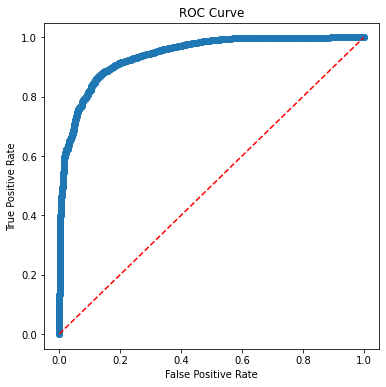

In [0]:
param_map = best_model.stages[-1].extractParamMap()
for p, v in param_map.items():
 print(p, v)
# Grab the model from Stage 3 of the pipeline
mymodel = best_model.stages[-1]
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'r--')
x = mymodel.summary.roc.select('FPR').collect()
y = mymodel.summary.roc.select('TPR').collect()
plt.scatter(x, y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("reviews_roc.png")

In [0]:
# Extract the coefficients on each of the variables
coeff = mymodel.coefficients.toArray().tolist()

# Loop through the features to extract the original column names. Store in the var_index dictionary
var_index = dict()

# Get the feature attributes metadata
feature_metadata = predictions.schema["features"].metadata.get("ml_attr", {}).get("attrs", {})

# Loop through numeric and binary features
for variable_type in ['numeric', 'binary']:
        for variable in feature_metadata.get(variable_type, []):
            print(f"Found {variable_type} variable: {variable}")
            idx = variable['idx']
            name = variable['name']
            var_index[idx] = name  # Add the name to the dictionary

# Loop through all of the variables found and print out the associated coefficient
for i in range(len(var_index)):
    print(i, var_index.get(i, 'Unknown'), coeff[i])


Found numeric variable: {'idx': 0, 'name': 'week_of_year_created'}
Found numeric variable: {'idx': 2, 'name': 'review_features_0'}
Found numeric variable: {'idx': 3, 'name': 'review_features_1'}
Found numeric variable: {'idx': 4, 'name': 'review_features_2'}
Found numeric variable: {'idx': 5, 'name': 'review_features_3'}
Found numeric variable: {'idx': 6, 'name': 'review_features_4'}
Found numeric variable: {'idx': 7, 'name': 'review_features_5'}
Found numeric variable: {'idx': 8, 'name': 'review_features_6'}
Found numeric variable: {'idx': 9, 'name': 'review_features_7'}
Found numeric variable: {'idx': 10, 'name': 'review_features_8'}
Found numeric variable: {'idx': 11, 'name': 'review_features_9'}
Found numeric variable: {'idx': 12, 'name': 'review_features_10'}
Found numeric variable: {'idx': 13, 'name': 'review_features_11'}
Found numeric variable: {'idx': 14, 'name': 'review_features_12'}
Found numeric variable: {'idx': 15, 'name': 'review_features_13'}
Found numeric variable: {'i

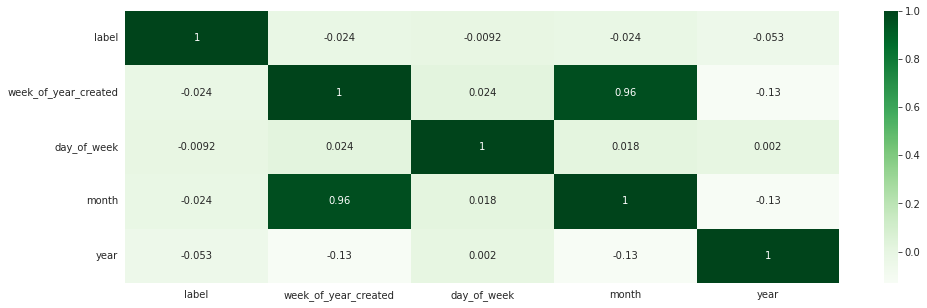

In [0]:
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
# Convert the numeric values to vector columns
vector_column = "correlation_features"
# Make a list of all of the numeric columns
numeric_columns = ['label', 'week_of_year_created', 'day_of_week', 'month', 'year']
# Use a vector assembler to combine all of the numeric columns together
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(sdf).select(vector_column)
# Create the correlation matrix, then get just the values and convert to a list
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()
# Convert the correlation to a Pandas dataframe
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns,
index=numeric_columns)
sns.set_style("white")
# Crate the plot using Seaborn
plt.figure(figsize=(16,5))
sns.heatmap(correlation_matrix_df,
xticklabels=correlation_matrix_df.columns.values,
yticklabels=correlation_matrix_df.columns.values, cmap="Greens", annot=True)
plt.savefig("correlation_matrix.png")

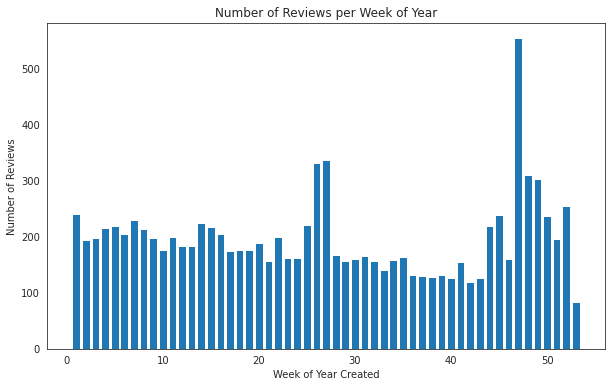

In [0]:
import matplotlib.pyplot as plt 

 
 

plot_data = sdf.groupBy('week_of_year_created').count().toPandas() 
plt.figure(figsize=(10, 6)) 

plt.bar(plot_data['week_of_year_created'], plot_data['count']) 

plt.xlabel('Week of Year Created') 

plt.ylabel('Number of Reviews') 

plt.title('Number of Reviews per Week of Year') 

plt.show() 

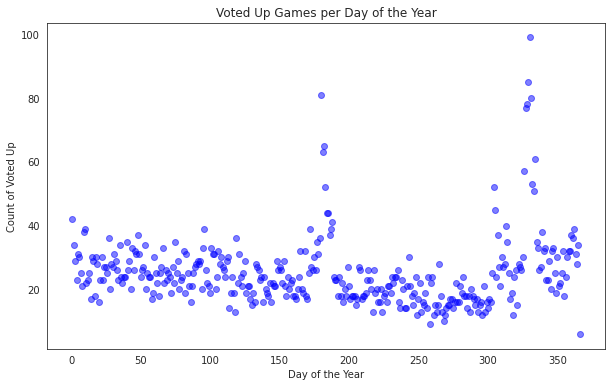

In [0]:
from pyspark.sql.functions import col, dayofyear, when

sdf = sdf.withColumn('day_of_year', dayofyear('timestamp_created_dt'))

sdf = sdf.withColumn('voted_up_int', when(col('voted_up'), 1).otherwise(0))

# Group by 'day_of_year' and sum the 'voted_up_int' column for each day
plot_data = sdf.groupBy('day_of_year').agg({'voted_up_int': 'sum'}).withColumnRenamed('sum(voted_up_int)', 'num_voted_up').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(plot_data['day_of_year'], plot_data['num_voted_up'], color='blue', alpha=0.5)

plt.xlabel('Day of the Year')
plt.ylabel('Count of Voted Up')
plt.title('Voted Up Games per Day of the Year')
plt.show()




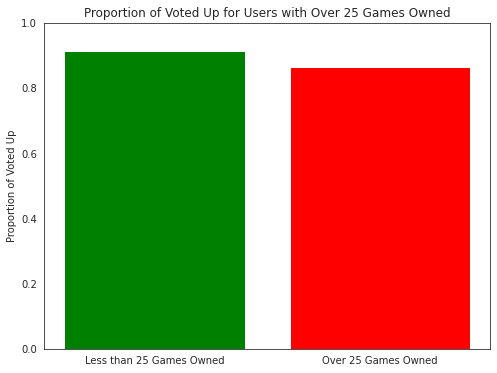

In [0]:

# Create a new column 'over_25_games_owned' based on the condition
sdf = sdf.withColumn('over_25_games_owned', when(col('num_games_owned') > 25, 1).otherwise(0))

# Convert boolean 'voted_up' column to integer for calculating proportion
sdf = sdf.withColumn('voted_up_int', when(col('voted_up'), 1).otherwise(0))

# Group by 'over_25_games_owned' and calculate the proportion of 'voted_up'
plot_data = sdf.groupBy('over_25_games_owned').agg({'voted_up_int': 'avg'}).withColumnRenamed('avg(voted_up_int)', 'proportion_voted_up').toPandas()

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(plot_data['over_25_games_owned'], plot_data['proportion_voted_up'], color=['red', 'green'])
plt.xticks([0, 1], ['Less than 25 Games Owned', 'Over 25 Games Owned'])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel('Proportion of Voted Up')
plt.title('Proportion of Voted Up for Users with Over 25 Games Owned')
plt.show()

     |████████████████████████████████| 1.5 MB 5.8 MB/s 
     |████████████████████████████████| 78 kB 9.2 MB/s 
     |████████████████████████████████| 773 kB 42.8 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-5194c5c5-8e2e-4c9b-a0a2-94db571a34af/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


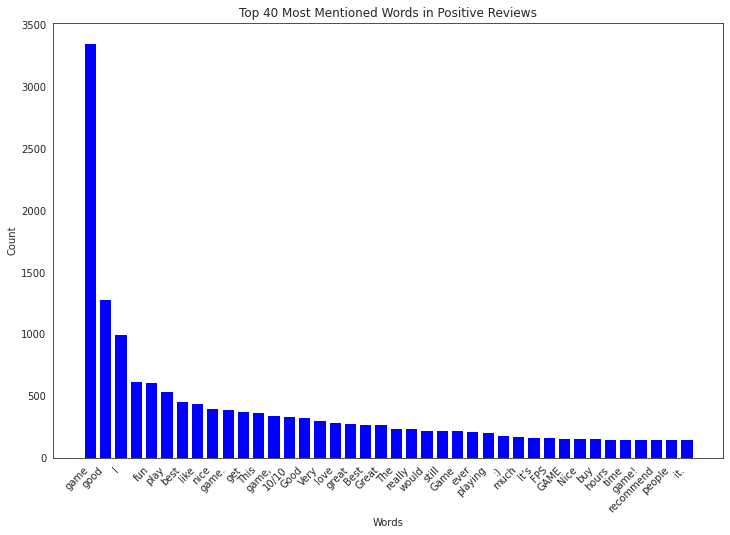

In [0]:
!pip install nltk

from pyspark.sql.functions import col, explode, split, desc
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

positive_reviews = sdf.filter(col('voted_up') == True).select('review')

# Tokenize the review column to help remove stop words later on
tokenized_reviews = positive_reviews.select(explode(split(col('review'), '\s+')).alias('word'))

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))
# Filtering out stopwords
filtered_reviews = tokenized_reviews.filter(~tokenized_reviews['word'].isin(stop_words))
# Counting the words
word_counts = filtered_reviews.groupBy('word').count()


sorted_word_counts = word_counts.orderBy(desc('count'))
top_words = sorted_word_counts.limit(40).toPandas()
plt.figure(figsize=(12, 8))
plt.bar(top_words['word'], top_words['count'], color='blue')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 40 Most Mentioned Words in Positive Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()